# Top Charts Song Classification

## Outline
1. <a href='#1'>Introduction</a>
2. <a href='#2'>Dataset Setup</a>
3. <a href='#3'>Results</a>
4. <a href='#4'>Discussion</a>

## 1. Introduction

## 2. Dataset Setup

### Imports

In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from spotipy import Spotify, oauth2
import secret
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import math
from datetime import datetime


In [152]:
def import_data():
    """
    Import all the song data from raw, unedited csv within this folder
    Returns csv as a dataframe object (still uncleaned)
    Link to Dataset on Kaggle: https://www.kaggle.com/datasets/multispiros/34740-hit-and-nonhit-songs-spotify-features?resource=download
    """
    unedited_song_data = pd.read_csv('unedited_song_data.csv')
    return unedited_song_data

### Spotify API Setup

#### SpotifyAPI Class Overview
- Each class instance takes in a Spotify API client id and secret, which can be retrieved by creating an app in a Spotify Developer account.
- Uses the spotipy library to validate credentials and create a Spotify API object, which is a field of the class (sp)
- Stores a list of tracks, artists, and artist popularities, which are initially empty but are populated by calling the appropriate function which each makes calls to the Spotify API

In [153]:
class SpotifyAPI:
    def __init__(self, client_id: str, client_secret: str):
        """
        Create a SpotifyAPI object
        
        :param client_id: Your Spotify client ID
        :param client_secret: Your Spotify client secret
        """
        credentials_manager = oauth2.SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
        self.sp = Spotify(client_credentials_manager=credentials_manager)
        self.artist_popularity = pd.DataFrame(columns=['Track ID', 'Artist ID', 'Artist Popularity'])
        self.tracks = []
        self.artists = []
    
    def get_tracks(self, track_ids):
        """
        Returns a json/dictionary of Spotify catalog information for a list of tracks based on their track Id.
        
        The endpoint that is hit and the response documentation are listed here: 
        https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-tracks
        
        :param track_ids: A list of Spotify Track Ids
            Max length: 50
            Raises Exception: the max length of the list of track id's is 50 to adhere to the endpoint's limit
        
        returns Spotify catalog information for the list of tracks and adds the track object to the class field self.tracks
        """
        if (len(track_ids) > 50): raise Exception("Limit is 50 tracks")

        try:
            track_objects = self.sp.tracks(tracks=track_ids)
            time.sleep(30)
        except Exception as se:
            print("Error details: {}".format(se))
            time.sleep(30)
        
        actual_tracks = track_objects['tracks']
        self.tracks.extend(actual_tracks)
        return actual_tracks
    
    def get_artist_popularity(self, track_ids):
        """
        Gets an artist popularity metric reported by Spotify for each of the tracks provided. Adds this information
        to the class's artist_popularity field which contains the Track ID, Artist ID, and Artist Popularity metric.
        
        The endpoint that is hit and the response documentation are listed here: 
        https://developer.spotify.com/documentation/web-api/reference/#/operations/get-multiple-artists
        
        Raises Exception if the rate limit is exceeded. 
        For prevention measures, suspends the execution by 30 seconds after each API call
        
        :param track_ids: A list of Spotify Track Ids
        """
        track_objects = self.get_tracks(track_ids)
        artist_ids = []
        artist_popularities = []
        for track in track_objects:
            primary_artist_id = track['artists'][0]['id']
            artist_ids.append(primary_artist_id)

        try:
            artist_objects_dict = self.sp.artists(artists=artist_ids)
            time.sleep(30)
        except Exception as se:
            print("Error details: {}".format(se))
            time.sleep(30)
        
        artist_objects = artist_objects_dict['artists']
        self.artists.extend(artist_objects)
        
        for artist in artist_objects:
            artist_popularities.append(artist['popularity'])
            
        artist_pop_df = pd.DataFrame({'Track ID': track_ids, 'Artist ID': artist_ids, 'Artist Popularity': artist_popularities})
        self.artist_popularity = pd.concat([self.artist_popularity, artist_pop_df], ignore_index=True)


#### Spotify API Clients

In [4]:
spotify_api_0 = SpotifyAPI(client_id=secret.spotify_client_id_tester, client_secret=secret.spotify_secret_key_tester)
spotify_api_1 = SpotifyAPI(client_id=secret.spotify_client_id_1, client_secret=secret.spotify_secret_key_1)
spotify_api_2 = SpotifyAPI(client_id=secret.spotify_client_id_2, client_secret=secret.spotify_secret_key_2)
spotify_api_3 = SpotifyAPI(client_id=secret.spotify_client_id_3, client_secret=secret.spotify_secret_key_3)
spotify_api_4 = SpotifyAPI(client_id=secret.spotify_client_id_4, client_secret=secret.spotify_secret_key_4)

In [5]:
spotify_clients = [spotify_api_0, spotify_api_1, spotify_api_2, spotify_api_3, spotify_api_4]

In [154]:
unedited_song_data = import_data()
stage1_song_data = unedited_song_data.copy().dropna() # drops 1 row
stage1_song_data['artist_name'] = stage1_song_data['artist_name'].str.strip()
dups_removed = stage1_song_data.drop_duplicates(subset=['artist_name']).reset_index()

In [155]:
# divides the data into 5 dataframes to run each of the 5 API clients with
fifths = np.array_split(dups_removed, 5)

In [156]:
# function to split dataframe into chunks of 50 since the Spotify API limits the call to 50 IDs
def split_dataframe(df, chunk_size = 50): 
    chunks = []
    num_chunks = math.ceil(len(df) / chunk_size)
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [157]:
def process_dataset_portion(idx):
    api = spotify_clients[idx]
    dataset_portion = fifths[idx]
    
    # Split dataframe into chunks of 50 to adhere to rate/size limit
    dataset_chunks = split_dataframe(dataset_portion)
    print('----------------------api:', idx, '   start:', datetime.now().strftime("%H:%M:%S"))
    i = 1
    for subset in dataset_chunks:
        track_ids = subset.track_id
        track_id_list = track_ids.tolist()
        api.get_artist_popularity(track_id_list)
        print('api:', idx, '   finished:', i)
        i+=1
    print('-----------------------api:', idx, '   end:', datetime.now().strftime("%H:%M:%S"))

In [13]:
# the spotify_api_[number] instance will have a field called artist_popularity which will be
# the dataframe with the resulting artist popularities after making the api calls

# process_dataset_portion(0)
# spotify_api_0.artist_popularity

In [14]:
# process_dataset_portion(1)
# spotify_api_1.artist_popularity

In [15]:
# process_dataset_portion(2)
# spotify_api_2.artist_popularity

In [16]:
# process_dataset_portion(3)
# spotify_api_3.artist_popularity

In [ ]:
# process_dataset_portion(4)
# spotify_api_4.artist_popularity

### Data Cleaning Methods

In [158]:
artist_pops = pd.concat([pd.read_csv('api_0.csv', index_col=0),
                        pd.read_csv('api_1.csv', index_col=0),
                        pd.read_csv('artist_popularity_2_3_4.csv')], ignore_index=True)

In [159]:
artist_pops = artist_pops.rename(columns={"Track ID": "track_id", "Artist ID": "artist_id", "Artist Popularity": "artist_popularity"})
artist_pops

,track_id,artist_id,artist_popularity
0,3FeufAV1f6fajILIQuAXMw,1InZHD4BodCnPawt9ivQzp,0
1,6nWoNNkfffbmHU9z3kGPao,3t5xRXzsuZmMDkQzgOX35S,83
2,5Zg1UOcmee5oiRw3gbXna0,5aIqB5nVVvmFsvSdExz408,81
3,3ZD7POEWTQETjyVzigY6mn,2wOqMjp9TyABvtHdOSOTUS,76
4,2y2iU8nqJGWpLfBeHbFInM,1iIxNEvPPmdFIIP0tdpw6G,72
...,...,...,...
10762,4cG7HUWYHBV6R6tHn1gxrl,7i9j813KFoSBMldGqlh2Z1,74
10763,7Bk0uXKk1uPT0XuQbpFzvs,0n6sKrG0xKAf8xmdqeNGke,76
10764,0awuNCj9gwJEM0seER22DW,7okSU80WTrn4LXlyXYbX3P,75
10765,7I8L3vYCLThw2FDrE6LuzE,3Apb2lGmGJaBmr0TTBJvIZ,76


In [85]:
merged_data = pd.merge(left=stage1_song_data, right=artist_pops, how='inner', on='track_id')

In [160]:
# contains each artist's id, name, and popularity
lookup_table = merged_data[['artist_name', 'artist_popularity']].dropna()

In [161]:
lookup_table

,artist_name,artist_popularity
0,Joe,0.0
2,Robin Schulz,83.0
3,Johann Sebastian Bach,81.0
67,Ludwig van Beethoven,76.0
79,Los Cadetes De Linares,72.0
...,...,...
34720,Riton,74.0
34725,Los Legendarios,76.0
34728,Clinton Kane,75.0
34734,Rusherking,76.0


In [162]:
# has popularity column
stage1_song_data = stage1_song_data.merge(lookup_table, how='left', on='artist_name')
stage1_song_data.to_csv('song_data_with_popularities')
stage1_song_data

,track_title,artist_name,track_id,duration_ms,energy,key,mode,time_signature,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart,artist_popularity
0,Red Planet - Red Planet Radio,Joe,3FeufAV1f6fajILIQuAXMw,256080,0.96800,7,0,4,0.02150,0.698,0.862000,0.1110,-11.012,0.0337,0.3900,136.884,0,0.0
1,Red Planet - Red Planet Extended,Joe,2o7oYjZuo3S2QitY4R5dII,395442,0.97000,2,1,4,0.00339,0.724,0.896000,0.1060,-8.415,0.0358,0.4320,136.868,0,0.0
2,Basejump,Robin Schulz,6nWoNNkfffbmHU9z3kGPao,391680,0.40600,5,0,4,0.00433,0.803,0.825000,0.0948,-9.444,0.0608,0.0769,125.014,0,83.0
3,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,5Zg1UOcmee5oiRw3gbXna0,347840,0.00267,7,0,5,0.91000,0.150,0.028700,0.1250,-24.701,0.0434,0.1050,135.652,0,81.0
4,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,2ZWmWGoZS2OTGZSnMhck7Q,181733,0.22600,7,1,4,0.76800,0.290,0.000002,0.1050,-14.990,0.0385,0.4700,98.348,0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34734,Además de Mí - Remix,Rusherking,7I8L3vYCLThw2FDrE6LuzE,330040,0.61300,6,1,4,0.03960,0.397,0.000000,0.1920,-5.077,0.0549,0.4050,78.400,1,76.0
34735,Drunk,Elle King & Miranda Lambert,0QULNNd9z5s35entfiiXoa,245626,0.88400,5,1,4,0.00516,0.612,0.000000,0.0997,-4.400,0.0459,0.6260,119.991,1,69.0
34736,Breaking Up Was Easy In The 90's,Sam Hunt,4sf2L157iEgAR7yrCNLgSq,215933,0.64900,9,1,4,0.23100,0.562,0.000000,0.3410,-5.400,0.0494,0.3760,145.913,1,76.0
34737,Nobody,Dylan Scott,5TWAIHYaOnYg4txfmCgon5,160707,0.74700,0,1,4,0.51900,0.573,0.000001,0.0867,-6.460,0.0319,0.6450,79.952,1,67.0


In [163]:
def clean_data(unedited_song_data):
    """
    Cleans the given csv by removing not helpful features from our database and
    replaces the artist_name column with the artist popularity metric from the
    Spotify API
    Returns the cleaned DataFrame
    :param unedited_song_data: the unedited and uncleaned DataFrame object
    """
    cleaned_song_data = unedited_song_data.copy().dropna()
    del cleaned_song_data['track_title']
    del cleaned_song_data['key']
    del cleaned_song_data['time_signature']
    del cleaned_song_data['artist_name']
    del cleaned_song_data['track_id']

    return cleaned_song_data
    

In [164]:
def scale_train_test_x(train, test, scaler = None):
    '''
    Standardizes the given train and test data.
    Returns the scaled train and test data
    :param train: the training data to scale
    :param test: the testing data to scale
    :param scaler: the scaler to use to standardize, else default is StandardScaler
    '''
    if scaler is None:
        scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    return train, test

In [165]:
def split_data(cleaned_song_data):
    """
    Splits the training data into a 75%/25% split with the 25% allotted for testing
    Scales the training data before using it to fit models
    Returns the data split into x_train, x_test, y_train and y_test
    :param cleaned_song_data: the cleaned DataFrame object 
    """
    song_y = cleaned_song_data['On_chart']
    song_x = cleaned_song_data.drop(['On_chart'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(song_x, song_y, test_size=0.25, random_state=5)
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    x_train, x_test = scale_train_test_x(x_train, x_test)
    return x_train, x_test, y_train, y_test

### Cleaning the Data

In [166]:
uncleaned_song_data = pd.read_csv('song_data_with_popularities', index_col=0)

In [167]:
uncleaned_song_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34739 entries, 0 to 34738
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_title        34739 non-null  object 
 1   artist_name        34739 non-null  object 
 2   track_id           34739 non-null  object 
 3   duration_ms        34739 non-null  int64  
 4   energy             34739 non-null  float64
 5   key                34739 non-null  int64  
 6   mode               34739 non-null  int64  
 7   time_signature     34739 non-null  int64  
 8   acousticness       34739 non-null  float64
 9   danceability       34739 non-null  float64
 10  instrumentalness   34739 non-null  float64
 11  liveness           34739 non-null  float64
 12  loudness           34739 non-null  float64
 13  speechiness        34739 non-null  float64
 14  valence            34739 non-null  float64
 15  tempo              34739 non-null  float64
 16  On_chart           347

In [168]:
cleaned_song_data = clean_data(uncleaned_song_data)

In [169]:
cleaned_song_data

,duration_ms,energy,mode,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart,artist_popularity
0,256080,0.96800,0,0.02150,0.698,0.862000,0.1110,-11.012,0.0337,0.3900,136.884,0,0.0
1,395442,0.97000,1,0.00339,0.724,0.896000,0.1060,-8.415,0.0358,0.4320,136.868,0,0.0
2,391680,0.40600,0,0.00433,0.803,0.825000,0.0948,-9.444,0.0608,0.0769,125.014,0,83.0
3,347840,0.00267,0,0.91000,0.150,0.028700,0.1250,-24.701,0.0434,0.1050,135.652,0,81.0
4,181733,0.22600,1,0.76800,0.290,0.000002,0.1050,-14.990,0.0385,0.4700,98.348,0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34734,330040,0.61300,1,0.03960,0.397,0.000000,0.1920,-5.077,0.0549,0.4050,78.400,1,76.0
34735,245626,0.88400,1,0.00516,0.612,0.000000,0.0997,-4.400,0.0459,0.6260,119.991,1,69.0
34736,215933,0.64900,1,0.23100,0.562,0.000000,0.3410,-5.400,0.0494,0.3760,145.913,1,76.0
34737,160707,0.74700,1,0.51900,0.573,0.000001,0.0867,-6.460,0.0319,0.6450,79.952,1,67.0


In [170]:
cleaned_song_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34739 entries, 0 to 34738
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   duration_ms        34739 non-null  int64  
 1   energy             34739 non-null  float64
 2   mode               34739 non-null  int64  
 3   acousticness       34739 non-null  float64
 4   danceability       34739 non-null  float64
 5   instrumentalness   34739 non-null  float64
 6   liveness           34739 non-null  float64
 7   loudness           34739 non-null  float64
 8   speechiness        34739 non-null  float64
 9   valence            34739 non-null  float64
 10  tempo              34739 non-null  float64
 11  On_chart           34739 non-null  int64  
 12  artist_popularity  34739 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 3.7 MB


In [86]:
features = cleaned_song_data['On_chart']
target = cleaned_song_data.drop(['On_chart'], axis=1)

### Training Models

In [171]:
def predict_model(model, x):
    '''
    Predicts the y values for the given x values using the given model.
    Returns the Y predictions
    :param model: the trained model to use for our prediction
    :param x: x data to get y predictions for
    '''
    y_pred = model.predict(x);
    return y_pred

In [90]:
def fit_classifier(classifier, x_train, y_train, num_estimators=4, kernel='rbf'):
    '''
    Trains a random forest classifier ensemble using the given x and y training data
    Returns the trained random forest model
    :param x_train: the x data to train our random forest model on
    :param y_train: the y data to train our random forest model on
    '''
    if (classifier == 'RandomForest'):
        cl = RandomForestClassifier(n_estimators=num_estimators)
    elif (classifier == 'AdaBoost'):
        cl = AdaBoostClassifier(n_estimators=num_estimators)
    elif (classifier == 'LogisticRegression'):
        cl = LogisticRegression()
    elif (classifier == 'SVC'):
        cl = SVC(kernel=kernel)
    cl.fit(x_train, y_train)
    return cl

In [255]:
def get_metrics(y_true, y_pred):
    '''
    Gets evaluation metrics confusion matrix, classification report, accuracy sore, precision score,
    recall score, f1 score and auc score
    for the given y true and y predicted values.
    Returns the confusion matrix, the classification report, the accuracy score, precision score,
    recall score, f1 score and the auc score
    :param model: the model we are getting metrics for based on its predictions
    :param x_test: the testing data we used to predict from
    :param y_true: the true y data 
    :param y_pred: the y data predicted by the model
    '''
    conf_matrix = confusion_matrix(y_true,y_pred)
    class_report = classification_report(y_true,y_pred)
    accuracy = accuracy_score(y_true,y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_sc = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return conf_matrix, class_report, accuracy, precision, recall, f1_sc, auc

    

In [189]:
## Split data to be used for training / testing for each model
x_train, x_test, y_train, y_test = split_data(cleaned_song_data)

In [256]:
n_estimators = range(1, 51)

def run_ensemble_classifier(classifier):
    metrics_test = []
    
    for ne in n_estimators:
        fit_cl = fit_classifier(classifier, x_train, y_train, ne)

        y_pred = predict_model(fit_cl, x_test)

        conf_matrix, class_report, accuracy, precision, recall, f1_sc, auc = get_metrics(y_test, y_pred)

        metrics_test.append({
            '# Trees': ne,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_sc,
            'AUC':auc
        })
    
    return pd.DataFrame(metrics_test).set_index('# Trees')
    

In [263]:
def run_nonensemble_classifiers(classifier, kernel='rbf'):
    fit_cl = fit_classifier(classifier, x_train, y_train, kernel=kernel)
    y_pred = predict_model(fit_cl, x_test)
    conf_matrix, class_report, accuracy, precision, recall, f1_sc, auc = get_metrics(y_test, y_pred)
    
    print('{} Classifier Metrics - Test Set'.format(classifier))
    tn, fp, fn, tp = conf_matrix.ravel()
    print('\n\nConfusion matrix:')
    print(conf_matrix)
    print(f'\n\nTrue Positives: {tp}, False Positives: {fp}, False Negatives: {fn}, True Negatives: {tn}\n')
    
    metrics = { 'Accuracy': [accuracy], 'Error': [1-accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score':[f1_sc], 'AUC':[auc]}
    metrics_train = pd.DataFrame.from_dict(metrics)
    print(f'Metrics for package {classifier} on the training set:\n\n{metrics_train}')
    
    return fit_cl

#### Random Forest Ensemble

In [191]:
rf_metrics = run_ensemble_classifier('RandomForest')

In [192]:
print('Random Forest Classifier Metrics - Test Set')
rf_metrics

Random Forest Classifier Metrics - Test Set


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
1,0.862752,0.864372,0.860792,0.862578,0.862753
2,0.859067,0.928140,0.778647,0.846847,0.916817
3,0.892458,0.894360,0.890244,0.892297,0.938574
4,0.888083,0.919443,0.850897,0.883843,0.947680
5,0.910075,0.905206,0.916245,0.910692,0.955347
6,0.901900,0.914964,0.886332,0.900421,0.956379
7,0.911341,0.907104,0.916705,0.911879,0.958940
8,0.907887,0.916393,0.897837,0.907020,0.961382
9,0.911917,0.907580,0.917395,0.912461,0.964632


In [200]:
print('# Estimators with Max Accuracy')
rf_metrics[rf_metrics.Accuracy == rf_metrics.Accuracy.max()]

# Estimators with Max Accuracy


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
25,0.919977,0.913477,0.927980,0.920671,0.969102
41,0.919977,0.914039,0.927289,0.920617,0.972440


In [195]:
print('# Estimators with Max Precision')
rf_metrics[rf_metrics.Precision == rf_metrics.Precision.max()]

# Estimators with Max Precision


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
2,0.859067,0.92814,0.778647,0.846847,0.916817


In [196]:
print('# Estimators with Max Recall')
rf_metrics[rf_metrics.Recall == rf_metrics.Recall.max()]

# Estimators with Max Recall


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
31,0.919632,0.910072,0.931431,0.920628,0.970933


In [197]:
print('# Estimators with Max F1 Score')
rf_metrics[rf_metrics['F1 Score'] == rf_metrics['F1 Score'].max()]

# Estimators with Max F1 Score


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
25,0.919977,0.913477,0.92798,0.920671,0.969102


In [198]:
print('# Estimators with Max AUC')
rf_metrics[rf_metrics.AUC == rf_metrics.AUC.max()]

# Estimators with Max AUC


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
43,0.919286,0.911492,0.9289,0.920114,0.9727


Text(0.5, 1.0, 'Random Forest Ensemble Evaluation Metrics Based on Number of Estimators')

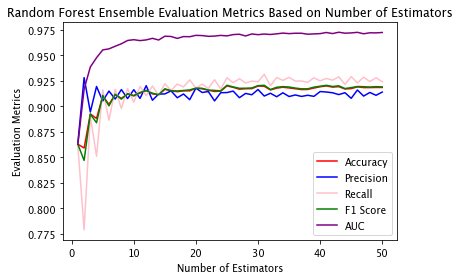

In [201]:
## plot all evaluation metrics as y values with estimator as x 
plt.plot(n_estimators, rf_metrics.Accuracy, color="red")
plt.plot(n_estimators, rf_metrics.Precision, color="blue")
plt.plot(n_estimators, rf_metrics.Recall, color="pink")
plt.plot(n_estimators, rf_metrics['F1 Score'], color="green")
plt.plot(n_estimators, rf_metrics.AUC, color="purple")
plt.legend(["Accuracy", "Precision", "Recall", "F1 Score", "AUC"])
plt.xlabel('Number of Estimators')
plt.ylabel('Evaluation Metrics')
plt.title('Random Forest Ensemble Evaluation Metrics Based on Number of Estimators')

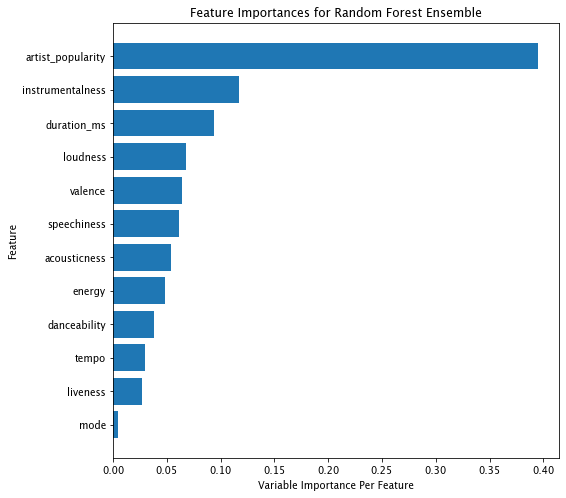

In [205]:
## plot feature importance of random forest using ensemble trained with
## 25 estimators, since this had the highest Accuracy & F1 Score
rfc = fit_classifier('RandomForest', x_train, y_train, num_estimators=25)
display_df = pd.DataFrame({'Features': cleaned_song_data.drop(['On_chart'], axis=1).columns,
                          'Importance': rfc.feature_importances_})
display_df.sort_values('Importance', inplace=True)

y_pos = np.arange(len(display_df.Features))

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

ax.barh(y_pos, display_df.Importance)
ax.set_xlabel('Variable Importance Per Feature')
ax.set_ylabel('Feature')
ax.set_title('Feature Importances for Random Forest Ensemble')
ax.set_yticks(y_pos, display_df.Features)
plt.show()

## AdaBoost

In [207]:
ada_metrics = run_ensemble_classifier('AdaBoost')

In [208]:
print('AdaBoost Classifier Metrics - Test Set')
ada_metrics

AdaBoost Classifier Metrics - Test Set


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
1,0.808866,0.774306,0.872296,0.820385,0.808815
2,0.850892,0.851417,0.850437,0.850927,0.869189
3,0.854922,0.875975,0.827197,0.850888,0.888875
4,0.854922,0.875975,0.827197,0.850888,0.897762
5,0.857110,0.863839,0.848136,0.855915,0.912216
6,0.860679,0.877468,0.838702,0.857647,0.922054
7,0.864018,0.875089,0.849517,0.862113,0.934219
8,0.866436,0.874119,0.856420,0.865179,0.939601
9,0.880253,0.855026,0.916015,0.884470,0.940690


In [211]:
print('# Estimators with Max Accuracy')
ada_metrics[ada_metrics.Accuracy == ada_metrics.Accuracy.max()]

# Estimators with Max Accuracy


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
41,0.900288,0.886667,0.918086,0.902103,0.959201


In [212]:
print('# Estimators with Max Precision')
ada_metrics[ada_metrics.Precision == ada_metrics.Precision.max()]

# Estimators with Max Precision


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
30,0.899136,0.888491,0.913023,0.90059,0.957817


In [213]:
print('# Estimators with Max Recall')
ada_metrics[ada_metrics.Recall == ada_metrics.Recall.max()]

# Estimators with Max Recall


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
25,0.897064,0.879507,0.920387,0.899483,0.956151


In [214]:
print('# Estimators with Max F1 Score')
ada_metrics[ada_metrics['F1 Score'] == ada_metrics['F1 Score'].max()]

# Estimators with Max F1 Score


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
41,0.900288,0.886667,0.918086,0.902103,0.959201


In [215]:
print('# Estimators with Max AUC')
ada_metrics[ada_metrics.AUC == ada_metrics.AUC.max()]

# Estimators with Max AUC


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
50,0.899021,0.888292,0.913023,0.900488,0.960441


Text(0.5, 1.0, 'AdaBoost Evaluation Metrics Based on Number of Estimators')

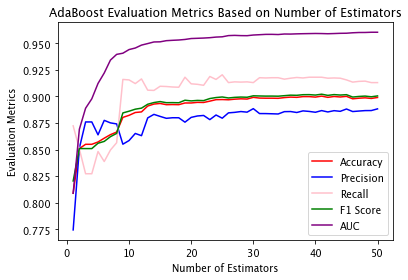

In [209]:
## plot all evaluation metrics as y values with estimator as x 
plt.plot(n_estimators, ada_metrics.Accuracy, color="red")
plt.plot(n_estimators, ada_metrics.Precision, color="blue")
plt.plot(n_estimators, ada_metrics.Recall, color="pink")
plt.plot(n_estimators, ada_metrics['F1 Score'], color="green")
plt.plot(n_estimators, ada_metrics.AUC, color="purple")
plt.legend(["Accuracy", "Precision", "Recall", "F1 Score", "AUC"])
plt.xlabel('Number of Estimators')
plt.ylabel('Evaluation Metrics')
plt.title('AdaBoost Evaluation Metrics Based on Number of Estimators')

## Logistic Regression

In [248]:
logr_clf = run_nonensemble_classifiers('LogisticRegression')

LogisticRegression Classifier Metrics - Test Set


 Confusion matrix:
[[3745  594]
 [ 419 3927]]


 True Positives: 3927, False Positives: 594, False Negatives: 419, True Negatives: 3745

Metrics for package LogisticRegression on the training set:

   Accuracy     Error  Precision   Recall  F1 Score       AUC
0  0.883362  0.116638   0.868613  0.90359  0.885756  0.883346


In [269]:
coefs = logr_clf.coef_
features = cleaned_song_data.drop(columns=['On_chart'])
print(f'Logistic Regression Coefficients:\n {coefs}')
f'The features that contribute the most are those with the largest absolute values. The most positively correlated features is {features.columns[np.where(coefs == coefs.max())[1][0]]} of {coefs.max()}, and the most negatively correlated features is {features.columns[np.where(coefs == coefs.min())[1][0]]} of {coefs.min()}.'



Logistic Regression Coefficients:
 [[ 0.27496841  0.04228138  0.17468446 -0.66165621 -0.0572976  -1.21659848
  -0.07219823  0.08475046 -0.67525945  0.64458129  0.02802437  2.12566066]]


'The features that contribute the most are those with the largest absolute values. The most positively correlated features is artist_popularity of 2.1256606600756793, and the most negatively correlated features is instrumentalness of -1.2165984776832128.'

In [258]:
# using testing data
thresholds =  [0.25, 0.5, 0.75, 0.9]
accuracies = []
errors = []
precisions = []
recalls = []
f1_scs = []
aucs = []
for threshold in thresholds:
    y_pred = (logr_clf.predict_proba(x_test)[:,1]>=threshold).astype(int)
    conf_matrix, class_report, accuracy, precision, recall, f1_sc, auc = get_metrics(y_test, y_pred)
    accuracies.append(accuracy)
    errors.append(1-accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scs.append(f1_sc)
    aucs.append(auc)
metrics = { 'Threshold': thresholds, 'Accuracy': accuracies, 'Error': errors, 'Precision': precisions, 'Recall': recalls, 'F1 Score':f1_scs, 'AUC':aucs}
metrics = pd.DataFrame.from_dict(metrics)
metrics.set_index('Threshold')

,Accuracy,Error,Precision,Recall,F1 Score,AUC
Threshold,,,,,,
0.25,0.861370,0.138630,0.803282,0.957432,0.873609,0.861293
0.50,0.883362,0.116638,0.868613,0.903590,0.885756,0.883346
0.75,0.854922,0.145078,0.919293,0.778417,0.843010,0.854984
0.90,0.764537,0.235463,0.957455,0.554073,0.701938,0.764706


## Support Vector Machine

### Nonlinear Kernel

In [250]:
n_svc_cl = run_nonensemble_classifiers('SVC')

SVC Classifier Metrics - Test Set


 Confusion matrix:
[[3870  469]
 [ 286 4060]]


 True Positives: 4060, False Positives: 469, False Negatives: 286, True Negatives: 3870

Metrics for package SVC on the training set:

   Accuracy     Error  Precision    Recall  F1 Score       AUC
0  0.913069  0.086931   0.896445  0.934192   0.91493  0.913051


### Linear Kernel

In [262]:
l_svc_cl = run_nonensemble_classifiers('SVC', kernel='linear')

SVC Classifier Metrics - Test Set


 Confusion matrix:
[[3728  611]
 [ 394 3952]]


 True Positives: 3952, False Positives: 611, False Negatives: 394, True Negatives: 3728

Metrics for package SVC on the training set:

   Accuracy     Error  Precision    Recall  F1 Score       AUC
0  0.884283  0.115717   0.866097  0.909342  0.887193  0.884263


## Model Metrics

In [ ]:
trained_classifiers = {
    'Random Forest' : rfc,
    'AdaBoost' : fit_classifier('AdaBoost', x_train, y_train, num_estimators=41),
    'Logistic Regression' : logr_clf,
    'Linear SVM' : l_svc_cl,
    'Nonlinear SVM' : n_svc_cl,
}

Model Metrics Comparison


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Random Forest'),
  Text(1, 0, 'AdaBoost'),
  Text(2, 0, 'Logistic Regression'),
  Text(3, 0, 'Linear SVM'),
  Text(4, 0, 'Nonlinear SVM')])

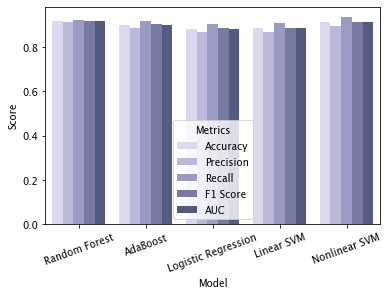

In [92]:
print('Model Metrics Comparison')
metrics = []
for classifier in trained_classifiers.keys():
    metrics.append([classifier, 'Accuracy', accuracy_score(y_pred = trained_classifiers[classifier].predict(x_test), y_true = y_test)])
    metrics.append([classifier, 'Precision', precision_score(y_pred = trained_classifiers[classifier].predict(x_test), y_true = y_test)])
    metrics.append([classifier, 'Recall', recall_score(y_pred = trained_classifiers[classifier].predict(x_test), y_true = y_test)])
    metrics.append([classifier, 'F1 Score', f1_score(y_pred = trained_classifiers[classifier].predict(x_test), y_true = y_test)])
    metrics.append([classifier, 'AUC', roc_auc_score(y_score = trained_classifiers[classifier].predict(x_test), y_true = y_test)])

metrics_df = pd.DataFrame(metrics, columns = ['Model', 'Metrics', 'Score'])
sns.barplot(x = metrics_df['Model'], y = metrics_df['Score'], hue = metrics_df['Metrics'], palette = 'ch:start=2.8,rot=.1,dark=.35')
plt.xticks(rotation = 20)